### Step 0. Requirements, colab-data

In [1]:
# !git clone https://github.com/AnnaMedved/Buildings-NN

# Ubcomment is using colab: 
# %cd /content/Buildings-NN
!pip install -r requirements.txt

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch-1.12.1-cp38-cp38-win_amd64.whl (161.9 MB)
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp38-cp38-win_amd64.whl size=76413 sha256=6fa62b11144d62c42a56d0fb74a81493b346b3c6a5d70ec2170c7f03669053e6
  Stored in directory: c:\users\анна\appdata\local\pip\cache\wheels\3e\08\ac\58126fe59992032701437336493f6132e1b72381a62d00b595
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=4d38d838080063d27b42b45dc6aaf1b4318ae08fceb670ee7a18e334f50bdcd6
  Stored in directory: c:\users\анна\appdata\local\pip\


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#  Libraries
import pandas as pd 
import os
import numpy as np
import json 
import random
import torch
import src.transforms as T
import src.utils as utils

from src.engine import train_one_epoch, evaluate
from src.dataset import FacadesDataset

# from pycocotools.coco import COCO
from src.coco import COCO
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
# Colab input data here
!pip install gdown
!gdown --fuzzy https://drive.google.com/file/d/1Z_QU_DLBf0qKvu-YwvwJ3ELNJeN5GZKU/view?usp=share_link

!pip install patool

import patoolib
!unzip buildings_train_v1.zip -d data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1Z_QU_DLBf0qKvu-YwvwJ3ELNJeN5GZKU
To: /content/Buildings-NN/buildings_train_v1.zip
100% 2.98M/2.98M [00:00<00:00, 75.1MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 4.0 MB/s eta 0:00:00
Archive:  buildings_train_v1.zip
   creating: data/images/
replace data/result.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/result.json        
  inflating: data/images/c5dbd92e-2e30f5e5d93b6a65d1602a43ac937a04.jpeg  
  inflating: data/images/98f7a26b-4d79ad1253c2f575b6bbd3ae4d4ee976.jpg  
  inflating: data/images/ab3eb062-3bb6718ca17378882c0e72401bf1317c.jpg  
  inflating: data/images/a181bd11-2d170cd26a3ec15f398c1f144dec4b8d.png  
  inflating: data/images/f1def932-1ed17320bacaabcb1bfd25aa76aa6d2b.jpg  
  inflating: data

### **Step 1**. Transform initial COCO data to the masks 

At first, let's see what's happening with photos

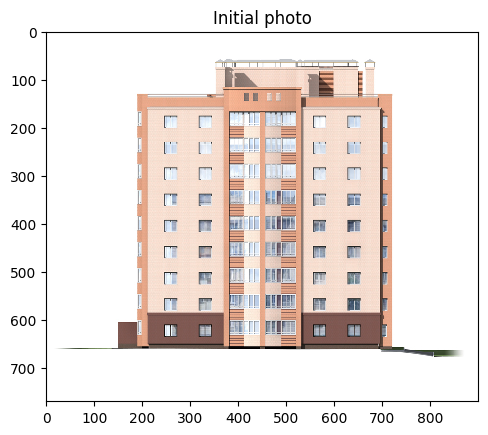

In [2]:
im_path = 'data/images'
res_path = 'data/result.json'

with open(res_path, 'r') as f: 
    res_json = json.load(f)
images_df = pd.DataFrame(res_json['images'])

# Get random photo and visualize it 
id_rand = random.randint(0, len(images_df)-1)
name_rand = images_df.loc[id_rand, 'file_name']
image = np.array(Image.open(os.path.join('data', name_rand)))
plt.imshow(image, interpolation='nearest')
plt.title('Initial photo')
plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


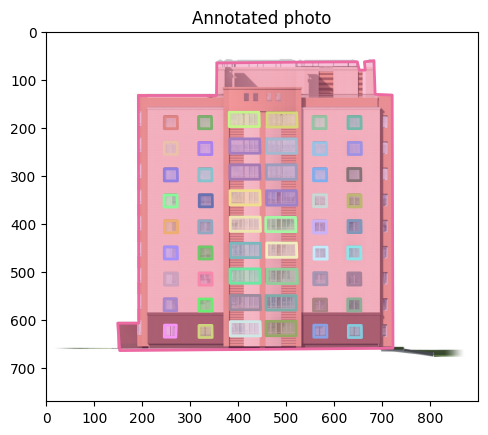

In [4]:
# Load the annotations from COCO format 
coco = COCO(res_path)
img = coco.imgs[id_rand]

# Visualize annotations 
plt.imshow(image)
plt.title('Annotated photo')
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

Text(0.5, 1.0, 'Mask-only')

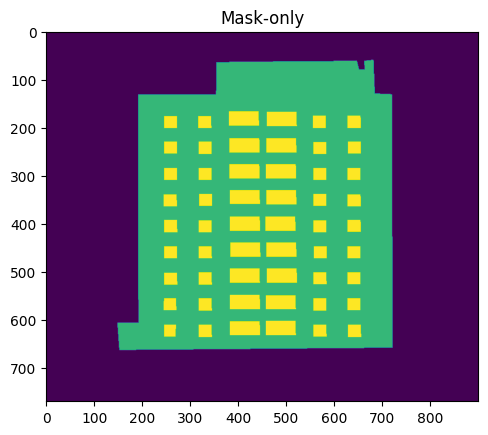

In [5]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)
plt.title('Mask-only')

... and creating these masks as part of the initializing FacadesDataset:

In [6]:
import src.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# trans = MyCompose([transform_ToNumpy()])

im_path = 'data/images'
res_path = 'data/result.json'

with open(res_path, 'r') as f: 
    res_json = json.load(f)
images_df = pd.DataFrame(res_json['images'])

data_dir = 'data'
coco_json = 'data/result.json'

# use our dataset and defined transformations
dataset_obj = FacadesDataset(
    data_path=data_dir, 
    coco_json_path=coco_json,
    transforms=get_transform(train=True)
    )
dataset_test_obj = FacadesDataset(
    data_path=data_dir, 
    coco_json_path=coco_json,
    transforms=get_transform(train=True)
    )

ids = images_df.id.unique()
train_ids = np.random.choice(a=ids, size=int(len(images_df)*0.75))
valid_ids = set(ids) - set(train_ids)
valid_ids = np.array(list(valid_ids))
# torch.manual_seed(5)
# indices = torch.randperm(len(dataset)).tolist()

# Split the dataset into train and test set
dataset = torch.utils.data.Subset(dataset_obj, train_ids)
dataset_test = torch.utils.data.Subset(dataset_test_obj, valid_ids)

# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [8]:
from src.mask import encode 

ds = dataset

for img_idx in range(len(ds)):
    # find better way to get target
    # targets = ds.get_annotations(img_idx)
    img, targets = ds[img_idx]
    image_id = targets["image_id"].item()
    img_dict = {}
    img_dict["id"] = image_id
    img_dict["height"] = img.shape[-2]
    img_dict["width"] = img.shape[-1]
    # dataset["images"].append(img_dict)
    bboxes = targets["boxes"].clone()
    bboxes[:, 2:] -= bboxes[:, :2]
    bboxes = bboxes.tolist()
    labels = targets["labels"].tolist()
    areas = targets["area"].tolist()
    iscrowd = targets["iscrowd"].tolist()

    if "masks" in targets:
        masks = targets["masks"]
        # make masks Fortran contiguous for coco_mask
        masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
    if "keypoints" in targets:
        keypoints = targets["keypoints"]
        keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
    num_objs = len(bboxes)
    
    for i in range(num_objs):
        ann = {}
        ann["image_id"] = image_id
        ann["bbox"] = bboxes[i]
        if "masks" in targets:
            # bimask = masks[i].numpy()
            try: 
                # mask = np.array(masks[i], dtype=int)
                # ann["segmentation"] = coco_mask.encode(bimask)
                init_mask = masks[i] # shape of (n, h, w)
                ann["segmentation"] = encode(init_mask)
            except Exception as e: 
                print('Numpy array datatype is still a problem')
                print(e)
                break
        if "keypoints" in targets:
            ann["keypoints"] = keypoints[i]
            ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
        dataset["annotations"].append(ann)

Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'
Numpy array datatype is still a problem
reshape() got an unexpected keyword argument 'order'


In [3]:
# boxes (FloatTensor[N, 4]):
dataset.__getitem__(0)[1]['boxes'].shape

torch.Size([49, 4])

In [5]:
# labels (Int64Tensor[N]):
dataset.__getitem__(0)[1]['labels'].shape

torch.Size([49])

In [4]:
# masks (UInt8Tensor[N, H, W]):
dataset.__getitem__(0)[1]['masks'].shape

torch.Size([2, 49, 24])

In [9]:
num_classes = 2
msks = dataset.__getitem__(0)[1]['masks']
# h, w = msks.shape

# # torch.reshape(msks, (num_classes, h, w))
# msks.expand(2, -1, -1)
msks.shape

torch.Size([2, 174, 18])

### **Step 2**. Model training and validation

Let's define our model and its parameters

In [5]:
from src.model_building import build_model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

c:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


... and finally the training

In [6]:
# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

c:\Python\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


KeyboardInterrupt: 